In [34]:
import numpy as np
import pandas as pd
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import re
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (accuracy_score, roc_auc_score, classification_report,confusion_matrix, RocCurveDisplay)
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay, average_precision_score, classification_report)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, roc_auc_score, classification_report, confusion_matrix)
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [35]:
#Mainting state

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [36]:
#Checking the columns

columns_path = "census-bureau.columns" 
data_path = "census-bureau.data"

with open(columns_path, "r") as f:
    columns = [c.strip() for c in f.readlines() if c.strip()]
        

#sanity check    
print(f"Number of columns in the dataset are: {len(columns)}")

print("\n")

print(columns[:40])



Number of columns in the dataset are: 42


['age', 'class of worker', 'detailed industry recode', 'detailed occupation recode', 'education', 'wage per hour', 'enroll in edu inst last wk', 'marital stat', 'major industry code', 'major occupation code', 'race', 'hispanic origin', 'sex', 'member of a labor union', 'reason for unemployment', 'full or part time employment stat', 'capital gains', 'capital losses', 'dividends from stocks', 'tax filer stat', 'region of previous residence', 'state of previous residence', 'detailed household and family stat', 'detailed household summary in household', 'weight', 'migration code-change in msa', 'migration code-change in reg', 'migration code-move within reg', 'live in this house 1 year ago', 'migration prev res in sunbelt', 'num persons worked for employer', 'family members under 18', 'country of birth father', 'country of birth mother', 'country of birth self', 'citizenship', 'own business or self employed', "fill inc questionnaire for veteran's 

In [37]:
#Loading the dataset

def load_raw_data(columns_path: str, data_path: str) -> pd.DataFrame:
    """
    Load CPS census data using the provided columns file and data file.
    Replaces '?' with NaN for easier missing-value handling.
    """
    # Load column names
    with open(columns_path, "r") as f:
        columns = [c.strip() for c in f.readlines() if c.strip()]

    # Load main dataset
    df = pd.read_csv(
        data_path,
        header=None,
        names=columns,
        na_values=["?"],   # CPS uses '?' for missing
    )
    return df

df= load_raw_data("census-bureau.columns", "census-bureau.data")


In [38]:
#sanity check for data
print("Dimensions of the input data is:", df.shape)
print(f"Data has {df.shape[0]} rows and {df.shape[1]} columns")

print("\n")


Dimensions of the input data is: (199523, 42)
Data has 199523 rows and 42 columns




In [39]:
#Data head

df.head(5)

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,label
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


In [40]:
#Checking null values
df.isna().sum()

age                                               0
class of worker                                   0
detailed industry recode                          0
detailed occupation recode                        0
education                                         0
wage per hour                                     0
enroll in edu inst last wk                        0
marital stat                                      0
major industry code                               0
major occupation code                             0
race                                              0
hispanic origin                                 874
sex                                               0
member of a labor union                           0
reason for unemployment                           0
full or part time employment stat                 0
capital gains                                     0
capital losses                                    0
dividends from stocks                             0
tax filer st

In [41]:
#This explains more about the data in terms of quantiles, mean values (if numerical) and standard devaition (to understand the skewness of data)
df.describe(include="all").transpose().head(42)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,199523.0,NaN,NaN,NaN,34.494199,22.310895,0.0,15.0,33.0,50.0,90.0
class of worker,199523,9,Not in universe,100245,NaN,NaN,NaN,NaN,NaN,NaN,NaN
detailed industry recode,199523.0,NaN,NaN,NaN,15.35232,18.067129,0.0,0.0,0.0,33.0,51.0
detailed occupation recode,199523.0,NaN,NaN,NaN,11.306556,14.454204,0.0,0.0,0.0,26.0,46.0
education,199523,17,High school graduate,48407,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wage per hour,199523.0,NaN,NaN,NaN,55.426908,274.896454,0.0,0.0,0.0,0.0,9999.0
enroll in edu inst last wk,199523,3,Not in universe,186943,NaN,NaN,NaN,NaN,NaN,NaN,NaN
marital stat,199523,7,Never married,86485,NaN,NaN,NaN,NaN,NaN,NaN,NaN
major industry code,199523,24,Not in universe or children,100684,NaN,NaN,NaN,NaN,NaN,NaN,NaN
major occupation code,199523,15,Not in universe,100684,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
#To understand the distribution of target variable
target_column = "label"   
df[target_column].value_counts(normalize=True)

label
- 50000.    0.937942
50000+.     0.062058
Name: proportion, dtype: float64

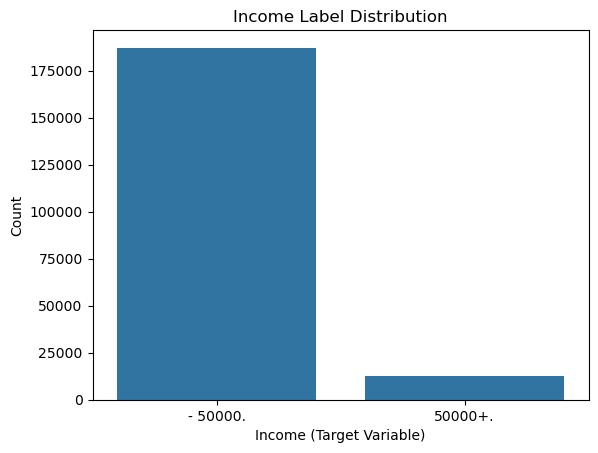

In [43]:
#Bar Plot for distribution

sns.countplot(x=target_column, data=df)
plt.title("Income Label Distribution")
plt.xlabel("Income (Target Variable)")
plt.ylabel("Count")
plt.show()

In [45]:
#Cleaning and Mapping the label column for standardization 


def clean_and_encode_label(df: pd.DataFrame, label_col: str = "label") -> pd.DataFrame:
    """
    Clean the raw income label and create:
    - 'income' (string: '<=50K' or '>50K')
    - 'income_binary' (0 for <=50K, 1 for >50K)
    """
    # Strip whitespace
    df[label_col] = df[label_col].astype(str).str.strip()

    # Map raw label codes to human-readable categories
    mapping = {
        "- 50000.": "<=50K",
        "50000+.": ">50K"
    }
    df["income"] = df[label_col].map(mapping)

    # Binary target for modeling
    df["income_binary"] = (df["income"] == ">50K").astype(int)
    return df


df = clean_and_encode_label(df)
# df["income"].value_counts(normalize=True




In [48]:
#Weighted Income Distribution

weighted_high_income = np.average(df['income_binary'], weights=df['weight'])
weighted_low_income = 1 - weighted_high_income

print("Weighted P(income >50K):", weighted_high_income)
print("Weighted P(income <=50K):", weighted_low_income)

Weighted P(income >50K): 0.06405041998278355
Weighted P(income <=50K): 0.9359495800172164


In [16]:
'''Creating a utility function for income weighted analysis'''

def weighted_income_rate(grp):
    return np.average(grp['income_binary'], weights=grp['weight'])



In [17]:
#Weighted Education based Income Distribution

edu_income_weighted = df.groupby("education").apply(weighted_income_rate)
edu_income_weighted = edu_income_weighted.sort_values(ascending=False)

edu_income_weighted

/var/folders/wd/0dqz73d12fvbyxwlp0lvtq5m0000gn/T/ipykernel_41311/4237983405.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  edu_income_weighted = df.groupby("education").apply(weighted_income_rate)


education
Prof school degree (MD DDS DVM LLB JD)    0.538923
Doctorate degree(PhD EdD)                 0.526257
Masters degree(MA MS MEng MEd MSW MBA)    0.315950
Bachelors degree(BA AB BS)                0.203474
Associates degree-academic program        0.096324
Associates degree-occup /vocational       0.075936
Some college but no degree                0.064957
High school graduate                      0.037622
12th grade no diploma                     0.014814
11th grade                                0.010311
7th and 8th grade                         0.008839
10th grade                                0.008342
5th or 6th grade                          0.006461
1st 2nd 3rd or 4th grade                  0.006410
9th grade                                 0.005961
Less than 1st grade                       0.000840
Children                                  0.000000
dtype: float64

/var/folders/wd/0dqz73d12fvbyxwlp0lvtq5m0000gn/T/ipykernel_41311/680069751.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=edu_income_weighted.index, y=edu_income_weighted.values, palette="viridis")


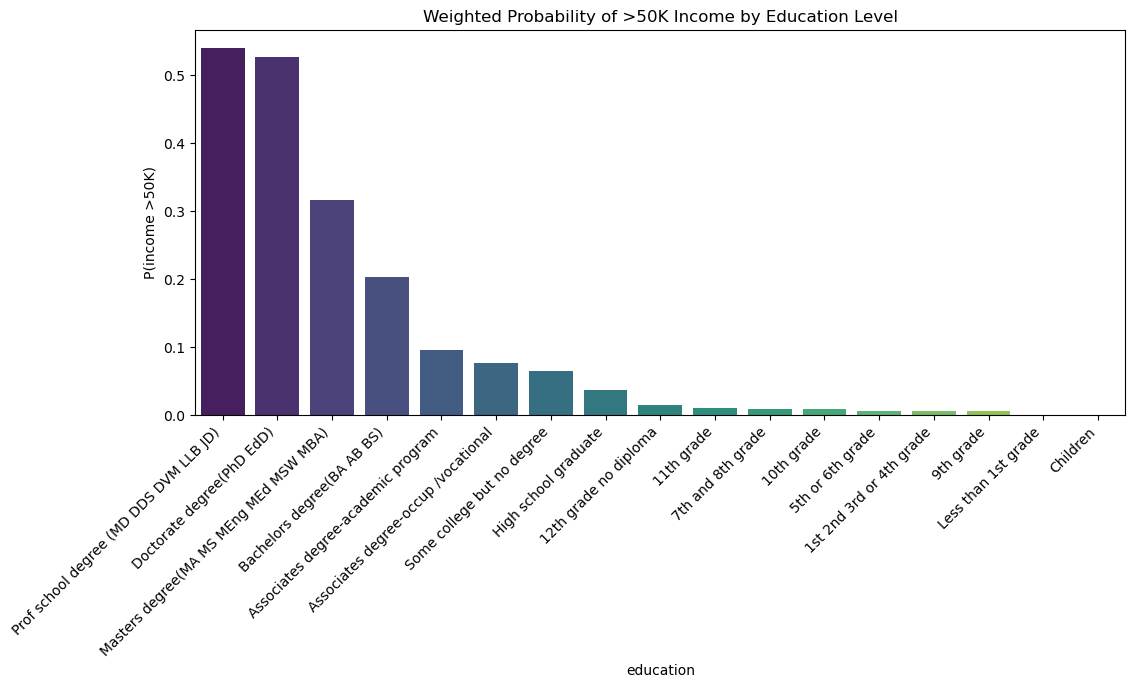

In [18]:
#plotting the education-Income distribution plot

plt.figure(figsize=(12, 5))
sns.barplot(x=edu_income_weighted.index, y=edu_income_weighted.values, palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.title("Weighted Probability of >50K Income by Education Level")
plt.ylabel("P(income >50K)")
plt.show()

In [19]:
#Weighted Occupation based Income Distribution

occ_income_weighted = df.groupby("major occupation code").apply(weighted_income_rate)
occ_income_weighted.sort_values(ascending=False).head(15)

/var/folders/wd/0dqz73d12fvbyxwlp0lvtq5m0000gn/T/ipykernel_41311/1107861622.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  occ_income_weighted = df.groupby("major occupation code").apply(weighted_income_rate)


major occupation code
Executive admin and managerial           0.290557
Professional specialty                   0.254143
Armed Forces                             0.199794
Protective services                      0.156763
Sales                                    0.132666
Technicians and related support          0.119937
Precision production craft & repair      0.088870
Transportation and material moving       0.063909
Farming forestry and fishing             0.043498
Machine operators assmblrs & inspctrs    0.038257
Adm support including clerical           0.030261
Handlers equip cleaners etc              0.017946
Other service                            0.010093
Not in universe                          0.009371
Private household services               0.003287
dtype: float64

/var/folders/wd/0dqz73d12fvbyxwlp0lvtq5m0000gn/T/ipykernel_41311/2905511261.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


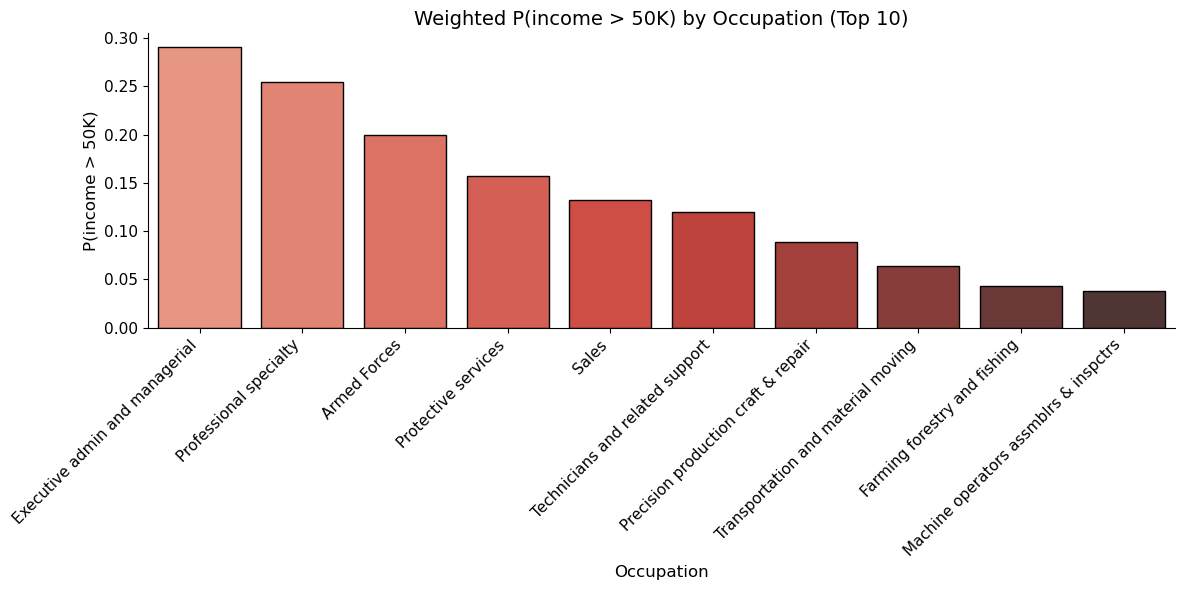

In [20]:
#plotting the top 10 Occupations drawing higher salary

top_occ = occ_income_weighted.sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))

sns.barplot(
    x=top_occ.index,
    y=top_occ.values,
    palette="Reds_d",
    edgecolor="black"
)

plt.xticks(rotation=45, ha="right", fontsize=11)
plt.yticks(fontsize=11)

plt.title("Weighted P(income > 50K) by Occupation (Top 10)", fontsize=14)
plt.xlabel("Occupation", fontsize=12)
plt.ylabel("P(income > 50K)", fontsize=12)

sns.despine()
plt.tight_layout()
plt.show()

In [21]:
#Age vs Income Weighted distribution 

df['age_bin'] = pd.cut(df['age'], bins=[0, 25, 35, 45, 55, 65, 90])
age_income_weighted = df.groupby("age_bin").apply(weighted_income_rate)
age_income_weighted

/var/folders/wd/0dqz73d12fvbyxwlp0lvtq5m0000gn/T/ipykernel_41311/4103093046.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_income_weighted = df.groupby("age_bin").apply(weighted_income_rate)
/var/folders/wd/0dqz73d12fvbyxwlp0lvtq5m0000gn/T/ipykernel_41311/4103093046.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  age_income_weighted = df.groupby("age_bin").apply(weighted_income_rate)


age_bin
(0, 25]     0.002414
(25, 35]    0.068674
(35, 45]    0.133957
(45, 55]    0.168525
(55, 65]    0.103703
(65, 90]    0.038603
dtype: float64

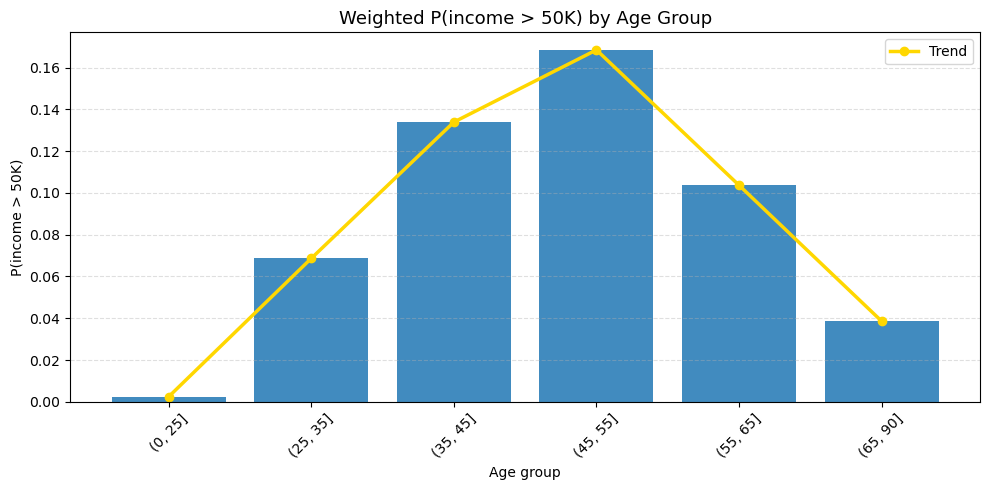

In [26]:
#Income - Age Weighted : Trend Analysis

y = age_income_weighted.values
x = np.arange(len(y))  # numeric positions for bins
labels = age_income_weighted.index.astype(str)

plt.figure(figsize=(10, 5))

# Bars
plt.bar(x, y, alpha=0.85)

# Trend line
plt.plot(
    x, y,
    color='gold',
    marker='o',
    linewidth=2.5,
    label='Trend'
)

# Aesthetics
plt.xticks(x, labels, rotation=45)
plt.title("Weighted P(income > 50K) by Age Group", fontsize=13)
plt.ylabel("P(income > 50K)")
plt.xlabel("Age group")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.legend()

plt.tight_layout()
plt.show()


**Findings:**

We can observe that the income grows with age → peaks around 45–55 → declines after 60. This finding is relevant as people get retired after 60


In [27]:
#Capital Gains - Income Weighted distribution

df.groupby("income")['capital gains'].apply(lambda x: np.average(x, weights=df.loc[x.index, 'weight']))

income
<=50K     144.574620
>50K     4781.242068
Name: capital gains, dtype: float64

**Reasoning:** 

1. *We can see  that capital gains is a high signal feature for income prediction analysis. It is one of the strongest separations between income groups. On a population weighted basis, individuals earning >50K report an average of 4,781 $ in capital gains versus only ~145$ for ≤50K earners — thats a 33x difference.*

2. *Although, this feature is sparse but is highly informative.*

In [28]:
#Class of worker - Income distributon

df.groupby("class of worker").apply(weighted_income_rate)

/var/folders/wd/0dqz73d12fvbyxwlp0lvtq5m0000gn/T/ipykernel_41311/241375771.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("class of worker").apply(weighted_income_rate)


class of worker
Federal government                0.210753
Local government                  0.112191
Never worked                      0.002939
Not in universe                   0.009402
Private                           0.102234
Self-employed-incorporated        0.362642
Self-employed-not incorporated    0.132921
State government                  0.117224
Without pay                       0.001849
dtype: float64

**Reasoning:**

1. *We can observe that federal and local goverment emoloyee have a higher probability of making more than 50K.*

In [30]:
#Marital status - Income distribution

df.groupby("marital stat").apply(weighted_income_rate)

/var/folders/wd/0dqz73d12fvbyxwlp0lvtq5m0000gn/T/ipykernel_41311/3825294960.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("marital stat").apply(weighted_income_rate)


marital stat
Divorced                           0.080676
Married-A F spouse present         0.024952
Married-civilian spouse present    0.119349
Married-spouse absent              0.055974
Never married                      0.013660
Separated                          0.050372
Widowed                            0.031974
dtype: float64

**Preprocessing and Modeling**

In [49]:
#Finding the column type. This is important because specific operations can be applied only on certain columns

def identify_feature_types(df: pd.DataFrame, weight_col: str = "weight", target_cols = ("income", "income_binary", "label")):
    """
    Identify numeric and categorical feature columns, excluding target and weight.
    """
    exclude = set(target_cols)
    if weight_col in df.columns:
        exclude.add(weight_col)

    cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
    num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

    # Remove targets and weight
    cat_cols = [c for c in cat_cols if c not in exclude]
    num_cols = [c for c in num_cols if c not in exclude]

    return cat_cols, num_cols

cat_cols, num_cols = identify_feature_types(df)


In [57]:
print("The categorical columns are" , cat_cols)

The categorical columns are ['class of worker', 'education', 'enroll in edu inst last wk', 'marital stat', 'major industry code', 'major occupation code', 'race', 'hispanic origin', 'sex', 'member of a labor union', 'reason for unemployment', 'full or part time employment stat', 'tax filer stat', 'region of previous residence', 'state of previous residence', 'detailed household and family stat', 'detailed household summary in household', 'migration code-change in msa', 'migration code-change in reg', 'migration code-move within reg', 'live in this house 1 year ago', 'migration prev res in sunbelt', 'family members under 18', 'country of birth father', 'country of birth mother', 'country of birth self', 'citizenship', "fill inc questionnaire for veteran's admin"]


In [56]:
print("The numeric columns are" , num_cols)

The numeric columns are ['age', 'detailed industry recode', 'detailed occupation recode', 'wage per hour', 'capital gains', 'capital losses', 'dividends from stocks', 'num persons worked for employer', 'own business or self employed', 'veterans benefits', 'weeks worked in year', 'year']


In [58]:

def impute_missing_values(df: pd.DataFrame, cat_cols, num_cols):
    """
    Imputing the missing values:
    - Categorical: replace NaN with 'Unknown'
    - Numeric: replace NaN with median

    This function returns a modified DataFrame (copy).
    """
    df = df.copy()

    # Categorical: create an explicit 'Unknown' category
    for col in cat_cols:
        df[col] = df[col].astype("category")
        df[col] = df[col].cat.add_categories("Unknown").fillna("Unknown")

    # Numeric: median imputation is robust to skew and outliers
    for col in num_cols:
        df[col] = df[col].fillna(df[col].median())

    return df


df_clean = impute_missing_values(df, cat_cols, num_cols)

In [59]:
df_clean

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,...,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,label,income,income_binary
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.,<=50K,0
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.,<=50K,0
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.,<=50K,0
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.,<=50K,0
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.,<=50K,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199518,87,Not in universe,0,0,7th and 8th grade,0,Not in universe,Married-civilian spouse present,Not in universe or children,Not in universe,...,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.,<=50K,0
199519,65,Self-employed-incorporated,37,2,11th grade,0,Not in universe,Married-civilian spouse present,Business and repair services,Executive admin and managerial,...,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.,<=50K,0
199520,47,Not in universe,0,0,Some college but no degree,0,Not in universe,Married-civilian spouse present,Not in universe or children,Not in universe,...,Germany,Foreign born- U S citizen by naturalization,0,Not in universe,2,52,95,- 50000.,<=50K,0
199521,16,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.,<=50K,0


In [60]:
def one_hot_encode(df: pd.DataFrame, cat_cols):
    """
    Applying one-hot encoding only to categorical columns.
    This function teturns transformed dataframe and the list of new dummy columns.
    """
    df = df.copy()
    df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)
    return df_encoded

df_encoded = one_hot_encode(df_clean, cat_cols)

In [61]:
df_encoded

,age,detailed industry recode,detailed occupation recode,wage per hour,capital gains,capital losses,dividends from stocks,weight,num persons worked for employer,own business or self employed,...,country of birth self_Yugoslavia,country of birth self_Unknown,citizenship_Foreign born- U S citizen by naturalization,citizenship_Native- Born abroad of American Parent(s),citizenship_Native- Born in Puerto Rico or U S Outlying,citizenship_Native- Born in the United States,citizenship_Unknown,fill inc questionnaire for veteran's admin_Not in universe,fill inc questionnaire for veteran's admin_Yes,fill inc questionnaire for veteran's admin_Unknown
0,73,0,0,0,0,0,0,1700.09,0,0,...,False,False,False,False,False,True,False,True,False,False
1,58,4,34,0,0,0,0,1053.55,1,0,...,False,False,False,False,False,True,False,True,False,False
2,18,0,0,0,0,0,0,991.95,0,0,...,False,False,False,False,False,False,False,True,False,False
3,9,0,0,0,0,0,0,1758.14,0,0,...,False,False,False,False,False,True,False,True,False,False
4,10,0,0,0,0,0,0,1069.16,0,0,...,False,False,False,False,False,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199518,87,0,0,0,0,0,0,955.27,0,0,...,False,False,False,False,False,True,False,True,False,False
199519,65,37,2,0,6418,0,9,687.19,1,0,...,False,False,False,False,False,True,False,True,False,False
199520,47,0,0,0,0,0,157,1923.03,6,0,...,False,False,True,False,False,False,False,True,False,False
199521,16,0,0,0,0,0,0,4664.87,0,0,...,False,False,False,False,False,True,False,True,False,False


In [62]:

def scale_numeric_features(X_train: pd.DataFrame, X_test: pd.DataFrame, num_cols):
    """
    Fitting a StandardScaler on numeric columns in X_train and apply it to both
    X_train and X_test. This returns transformed dataframes and the fitted scaler. 

    This step is important because we saw some of the values (for example - capital gains) had a 
    higher Standad Deviation compared to other values

    """
    scaler = StandardScaler()

    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()

    X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
    X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

    return X_train_scaled, X_test_scaled, scaler

In [65]:
def build_model_matrix(df: pd.DataFrame,
                       weight_col: str = "weight"):
    """
    This function is for End-to-end preparation:
    - identifies feature types
    - impute missing values
    - one-hot encode categoricals
    - split into X, y, weights
    """
    #Identifies feature types
    cat_cols, num_cols = identify_feature_types(df, weight_col=weight_col)

    #Imputes missing values
    df_imputed = impute_missing_values(df, cat_cols, num_cols)

    #keeps the weight separate
    sample_weight = df_imputed[weight_col].values if weight_col in df_imputed.columns else None

    #One-hot encodes the data
    df_encoded = one_hot_encode(df_imputed, cat_cols)

    #Targets
    y = df_encoded["income_binary"].astype(int)
    X = df_encoded.drop(columns=["income_binary", "income", "label"])

    # Drop weight from X (we usually do not feed it as a feature)
    if weight_col in X.columns:
        X = X.drop(columns=[weight_col])

    return X, y, sample_weight, num_cols



X, y, sample_weight, num_cols = build_model_matrix(df, weight_col="weight")

#Splitting the data in train and test set along with stratification. Used a test set of 20% 
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, sample_weight, test_size=0.2, random_state=42, stratify=y)

print("X_train's shape is:", X_train.shape)
print("\n")
print("y_train's shape is:", y_train.shape)
print("\n")
print("X_test's shape is:", X_test.shape)
print("\n")
print("y_test's shape is:", y_test.shape)


X_train's shape is: (159618, 399)


y_train's shape is: (159618,)


X_test's shape is: (39905, 399)


y_test's shape is: (39905,)


In [66]:

#Scales numeric features (this is important for our baseline models such as logistic regression)
X_train_scaled, X_test_scaled, scaler = scale_numeric_features(X_train, X_test, num_cols=[c for c in num_cols if c in X_train.columns])


**Synthetic Minority Oversampling Technique (SMOTE)**

In [67]:
#This is a famous technique used to handle class imblanace that we also observed in previous section for >50K label

smote = SMOTE(random_state=42, k_neighbors=5)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", np.bincount(y_train))
print("After SMOTE:", np.bincount(y_train_resampled))

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Before SMOTE: [149712   9906]
After SMOTE: [149712 149712]


In [68]:
#Scaling/Standardizing the SMOTE sampled data points as well
X_train_scaled, X_test_scaled, scaler = scale_numeric_features(X_train_resampled, X_test, num_cols=[c for c in num_cols if c in X_train.columns])

**Baseline 1: Logistic Regression**

In [69]:
log_clf = LogisticRegression(max_iter=2000, n_jobs=-1,class_weight=None)

log_clf.fit(X_train_scaled, y_train_resampled)


LogisticRegression(max_iter=2000, n_jobs=-1)

In [70]:
#Predicitng probabilitis on unseen test set

y_pred_log = log_clf.predict(X_test_scaled)
y_proba_log = log_clf.predict_proba(X_test_scaled)[:, 1]


In [ ]:

print("Logistic Regression: Area under curve:", roc_auc_score(y_test, y_proba_log))
print("\nClassification Report:\n", classification_report(y_test, y_pred_log))

In [ ]:
rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
    class_weight=None    # SMOTE already balanced the data
)



In [ ]:
rf_clf.fit(X_train_resampled, y_train_resampled)


In [ ]:
#predicting RF on unseen test set

y_pred_rf = rf_clf.predict(X_test)
y_proba_rf = rf_clf.predict_proba(X_test)[:, 1]

In [ ]:
print("Random Forest — Area under the curve:", roc_auc_score(y_test, y_proba_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

In [ ]:
top20_sorted = top20.sort_values(ascending=True)

plt.figure(figsize=(10, 8))

sns.barplot(
    x=top20_sorted.values,
    y=top20_sorted.index,
    palette="viridis",        # Beautiful gradient palette
    edgecolor="red"
)

# Titles & labels
plt.title("Top 20 Feature Importances — Random Forest", fontsize=14, pad=15)
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("Feature", fontsize=12)

# Improve tick readability
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Gridlines for easier comparison
plt.grid(axis='x', linestyle='--', alpha=0.2)

sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()



In [ ]:
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos
print("Negatives:", neg, "Positives:", pos, "scale_pos_weight:", scale_pos_weight)

In [ ]:
xgb_base = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",     
    tree_method="hist",        
    use_label_encoder=False,
    scale_pos_weight=scale_pos_weight,
    random_state=42
)


In [ ]:
#replacing some unimportant characters

def clean_col(col):
    col = str(col)
    col = re.sub(r"[\[\]<>]", "_", col)   
    col = col.replace(" ", "_")
    return col

X_train_scaled = X_train_scaled.rename(columns=clean_col)
X_test_scaled  = X_test_scaled.rename(columns=clean_col)

In [ ]:
xgb_clf = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",      # avoids warning
    tree_method="hist",         # fast for tabular
    use_label_encoder=False,
    scale_pos_weight=scale_pos_weight,
    n_estimators=250,
    max_depth=4,
    learning_rate=0.07,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_clf.fit(X_train_scaled, y_train_resampled)



In [ ]:
#predicting XGB boost on unseen test set

y_pred_xgb = xgb_clf.predict(X_test_scaled)
y_proba_xgb = xgb_clf.predict_proba(X_test_scaled)[:, 1]

print("XGBoost ROC-AUC:", roc_auc_score(y_test, y_proba_xgb))
print("\nClassification report (threshold = 0.5):\n")
print(classification_report(y_test, y_pred_xgb))

cm = confusion_matrix(y_test, y_pred_xgb)
print("Confusion matrix:\n", cm)

In [ ]:
#plotting the ROC curve

plt.figure(figsize=(6, 5))
RocCurveDisplay.from_predictions(y_test, y_proba_xgb)
plt.title("ROC Curve — XGBoost (Test Set)")
plt.tight_layout()
plt.show()


In [ ]:
cluster_df = df_clean.copy()


drop_cols = ["income", "income_binary", "label"]
if "weight" in cluster_df.columns:
    drop_cols.append("weight")

cluster_df = cluster_df.drop(columns=drop_cols)
cluster_df.head()

In [ ]:
#category coding important for clustering. 

cluster_cat_cols = cluster_df.select_dtypes(include=["object", "category"]).columns

for col in cluster_cat_cols:
    cluster_df[col] = cluster_df[col].astype("category").cat.codes

In [ ]:


scaler_cluster = StandardScaler()
cluster_scaled = scaler_cluster.fit_transform(cluster_df)
cluster_scaled.shape

In [ ]:
cluster_scaled 

In [ ]:
#finding best k on a holdout set as running it on entire setwas computatonally expensive.

sample_frac = 0.20
cluster_sample = cluster_scaled[np.random.choice(
    cluster_scaled.shape[0],
    int(cluster_scaled.shape[0] * sample_frac),
    replace=False
)]

In [ ]:
#using silhoute score for finding best k value


sil_scores = {}

for k in range(2, 9):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(cluster_sample)
    score = silhouette_score(cluster_sample, labels)
    sil_scores[k] = score
    print(f"K={k}, silhouette={score:.4f}")

In [ ]:
#Silhoute v/s Number of cluster visualization

plt.figure(figsize=(6,4))
plt.plot(list(sil_scores.keys()), list(sil_scores.values()), marker="o")
plt.xlabel("Number of clusters (K)")
plt.ylabel("Silhouette score")
plt.title("Silhouette Score vs K (KMeans)")
plt.tight_layout()
plt.show()

In [ ]:
#selecting best k value based on silhouette score

BEST_K = 4 

In [ ]:
kmeans = KMeans(n_clusters=BEST_K, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(cluster_scaled)

df["cluster"] = cluster_labels
df["cluster"].value_counts(normalize=True)

In [ ]:
#removing children from the cluster

adult_df = df_clean[df_clean["education"] != "Children"].copy()



In [ ]:
# Mapping education to ordered levels

edu_order = {
    "Less than 1st grade": 1,
    "1st 2nd 3rd or 4th grade": 2,
    "5th or 6th grade": 3,
    "7th and 8th grade": 4,
    "9th grade": 5,
    "10th grade": 6,
    "11th grade": 7,
    "12th grade no diploma": 8,
    "High school graduate": 9,
    "Some college but no degree": 10,
    "Associates degree-academic program": 11,
    "Associates degree-occup /vocational": 12,
    "Bachelors degree(BA AB BS)": 13,
    "Masters degree(MA MS MEng MEd MSW MBA)": 14,
    "Doctorate degree(PhD EdD)": 15,
    "Prof school degree (MD DDS DVM LLB JD)": 16,
}


In [ ]:
adult_df["education_level"] = adult_df["education"].map(edu_order)

features_for_clust = adult_df[["age", "weeks worked in year", "education_level", "capital gains"]]


In [ ]:
scaler = StandardScaler()
X_clust = scaler.fit_transform(features_for_clust)

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
adult_df["cluster"] = kmeans.fit_predict(X_clust)

In [ ]:
cluster_summary_2 = adult_df.groupby("cluster").agg({
    "age": ["mean", "median"],
    "weeks worked in year": ["mean", "median"],
    "education": lambda x: x.mode().iloc[0],
    "marital stat": lambda x: x.mode().iloc[0],
    "major occupation code": lambda x: x.mode().iloc[0],
    "income_binary": "mean"
})

# Rename lambda columns
cluster_summary_2.columns = [
    "age_mean", "age_median",
    "weeks_worked_mean", "weeks_worked_median",
    "education_mode",
    "marital_status_mode",
    "occupation_mode",
    "income_binary_mean"
]

cluster_summary_2

In [ ]:
'''Understanding Cluster distribution in terms of observation and probability of having income greater than 50K'''

cluster_size = df_adults["cluster"].value_counts().sort_index()
cluster_income = df_adults.groupby("cluster")["income_binary"].mean()

cluster_overview = pd.DataFrame({
    "n_obs": cluster_size,
    "p_income_gt_50k": cluster_income
})

cluster_overview

In [ ]:
cluster_income.plot(kind="bar", figsize=(6,4), edgecolor="black")
plt.title("P(income > 50K) by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Proportion > 50K")
plt.tight_layout()
plt.show()

In [ ]:
df_adults.groupby("cluster")["age"].mean().plot(kind="bar", figsize=(6,4), edgecolor="black")
plt.title("Average Age by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Mean Age")
plt.tight_layout()
plt.show()